# Kaggle: House Price Prediction Challenge

In [ ]:
# Import Core modules
import pandas as pd
import numpy as np

# Import modules for vizualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_rows", None, "display.max_columns", None)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load Data into pandas dataframe
housing_train = pd.read_csv('./data/train.csv')

In [ ]:
# Load test Data into pandas dataframe
housing_test = pd.read_csv('./data/test.csv')

In [ ]:
housing_train.shape

In [ ]:
housing_test.shape

In [ ]:
# Drop the id column from both train and test data
housing_train = housing_train.drop("Id", axis=1)
housing_test = housing_test.drop("Id", axis=1)

In [ ]:
len(housing_train.select_dtypes(include=['object']).columns)

In [ ]:
housing_train['SalePrice'].describe()

In [ ]:
# Correlations 
corr = housing_train.corr()

f, ax = plt.subplots(figsize=(15,15))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220,10,as_cmap=True), square=True, ax=ax, vmin=-1.0, vmax=1.0,
           linewidths=0.5)

In [ ]:
# Sorted list of corrs among all attribs and target var SalePrice
corr['SalePrice'].sort_values(ascending=False)

## Data Preprocessing

In [ ]:
housing_train.isnull().sum().sort_values(ascending=False)

In [ ]:
housing_test.isnull().sum().sort_values(ascending=False)

In [ ]:
housing_train_processed = housing_train
housing_test_processed = housing_test

In [ ]:
# Categorical Columns:
cat_cols_fill_node = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                      'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType',
                      'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond',
                      'MasVnrType', 'MSZoning', 'Functional', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']

# Replace missing values for categorical columns with None
for cat in cat_cols_fill_node:
    housing_train_processed[cat] = housing_train_processed[cat].fillna('None')
    housing_test_processed[cat] = housing_test_processed[cat].fillna('None')


    
# Group by neighbourhood and fill in missing value by the median Lotfrontage of all the neighborhood
housing_train_processed['LotFrontage'] = housing_train_processed.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
housing_test_processed['LotFrontage'] = housing_test_processed.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Garage: GarageYrBlt, GarageArea are GarageCars, these are numerical columns, replace with zero
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']:
    housing_train_processed[col] = housing_train_processed[col].fillna(int(0))
    housing_test_processed[col] = housing_test_processed[col].fillna(int(0))
    
# MasVnrArea : Replace with 0
housing_train_processed['MasVnrArea'] = housing_train_processed['MasVnrArea'].fillna(int(0))
housing_test_processed['MasVnrArea'] = housing_test_processed['MasVnrArea'].fillna(int(0))

# Use the mode value for Electrical and TotalBsmtSF
housing_train_processed['Electrical'] = housing_train_processed['Electrical'].fillna(housing_train_processed['Electrical']).mode()[0]
housing_test_processed['Electrical'] = housing_test_processed['Electrical'].fillna(housing_test_processed['Electrical']).mode()[0]
housing_test_processed['TotalBsmtSF'] = housing_test_processed['TotalBsmtSF'].fillna(housing_test_processed['TotalBsmtSF']).mode()[0]

# There is no need of Utilities so let's just drop this column
housing_train_processed = housing_train_processed.drop(['Utilities'], axis=1)
housing_test_processed = housing_test_processed.drop(['Utilities'], axis=1)

In [ ]:
# Get the count again to verify that we do not have any more missing value
housing_train_processed.isnull().apply(sum).max()

In [ ]:
housing_test_processed.isnull().apply(sum).max()

## Dealing with Outliers

In [ ]:
num_attribues_train = housing_train_processed.select_dtypes(exclude='object')
num_attribues_test = housing_test_processed.select_dtypes(exclude='object')

high_quant_train = housing_train_processed.quantile(0.999)
high_quant_test = housing_test_processed.quantile(0.999)

for i in num_attribues_train.columns:
    housing_train_processed = housing_train_processed.drop(housing_train_processed[i][housing_train_processed[i]>high_quant_train[i]].index)
for i in num_attribues_test.columns:
    housing_test_processed = housing_test_processed.drop(housing_test_processed[i][housing_test_processed[i]>high_quant_test[i]].index)

In [ ]:
housing_train_processed.info()

In [ ]:
housing_test_processed.info()

## Dealing with Correlated Attributes

In [ ]:
# Remove highly correlated attributes
attributes_drop = ['MiscVal', 'MoSold', 'YrSold', 'BsmtFinSF2', 'BsmtHalfBath', 'MSSubClass',
                   'GarageArea', 'GarageYrBlt', '3SsnPorch']

housing_train_processed = housing_train_processed.drop(attributes_drop, axis=1)
housing_test_processed = housing_test_processed.drop(attributes_drop, axis=1)

## Handle text and categorical attributes

In [ ]:
# Transforming cat variables
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_train_processed_1hot = cat_encoder.fit_transform(housing_train_processed)
housing_test_processed_1hot = cat_encoder.fit_transform(housing_test_processed)

In [ ]:
housing_test_processed_1hot

In [ ]:
housing_train_processed_1hot

# Data Transformation : Pipeline

In [ ]:
# Numerical Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# separate features and Target variable in the train set
housing_train_X = housing_train_processed.drop('SalePrice', axis=1)
housing_train_y = housing_train_processed['SalePrice'].copy()

# Separate numerical and Categorical attributes in lists
train_num_attributes = housing_train_X.select_dtypes(exclude='object')
train_cat_attributes = housing_train_X.select_dtypes(include='object')
test_num_attributes = housing_test_processed.select_dtypes(exclude='object')
test_cat_attributes = housing_test_processed.select_dtypes(include='object')

train_num_attribs = list(train_num_attributes)
train_cat_attribs = list(train_cat_attributes)
test_num_attribs = list(test_num_attributes)
test_cat_attribs = list(test_cat_attributes)

In [ ]:
# Numerical pipelines to impute any missing value with median amd scale attributes
num_pipeline_train = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
num_pipeline_test = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

In [ ]:
# using num pipeline
full_pipeline_train = ColumnTransformer([
    ("num", num_pipeline_train, train_num_attribs),
    ("cat", OneHotEncoder(), train_cat_attribs),
])

full_pipeline_test = ColumnTransformer([
    ("num", num_pipeline_test, test_num_attribs),
    ("cat", OneHotEncoder(), test_cat_attribs),
])

In [ ]:
housing_train_y.describe()

In [ ]:
# Apply log transform to SalePrice
housing_train_y_prepared = np.log(housing_train_y)

In [ ]:
housing_train_y_prepared.describe()

In [ ]:
# Run the transformation pipeline on all other attributes in train and test sets
housing_train_X_prepared = full_pipeline_train.fit_transform(housing_train_X)
housing_test_prepared = full_pipeline_test.fit_transform(housing_test_processed)

In [ ]:
housing_train_X_prepared

In [ ]:
housing_test_prepared

## Create ML Model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing_train_X_prepared, housing_train_y_prepared, test_size=0.2, random_state=7)

In [ ]:
# Inverse of log to change the SalePrice back to original : Invert the log-transformed value
def inv_y(transformed_y):
    return np.exp(transformed_y)

In [ ]:
# Testing on LinearRegression
# import modules
from sklearn.linear_model import LinearRegression

# Train the model on training data
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model on test data
print("Accuracy%:", model.score(X_test, y_test)*100)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Model: Random Forest. Define the model. ==============================================
rf_model = RandomForestRegressor(random_state=5)
rf_model.fit(X_train, y_train)

rf_val_predictions = rf_model.predict(X_test)
rf_val_rmse = mean_squared_error(inv_y(rf_val_predictions), inv_y(y_test))
rf_val_rmse = np.sqrt(rf_val_rmse)
rf_score = rf_model.score(X_test, y_test)*100

In [ ]:
print(rf_val_rmse)

In [ ]:
print(rf_score)

## Evaluation using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform K fold cross-validation, where K=10
scores = cross_val_score(rf_model, X_train, y_train,
                        scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())
    
display_scores(rf_rmse_scores)

In [ ]:
import joblib

# Save the model
joblib.dump(rf_model, "Kaggle_RF_model.pkl")

## Fine Tuning the model

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameters for exploraion
param_grid = [
    {'n_estimators': [10, 50, 100, 150], 'max_features': [10, 20, 30, 40, 50, 100, 150]},
    {'bootstrap': [False], 'n_estimators': [10, 50, 100, 150], 'max_features': [10, 20, 30, 40, 50, 100, 150]},
]

# The model for whcich we are finding params values
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

## Evaluate using the best params

In [ ]:
rf_model_final = RandomForestRegressor(bootstrap=False, max_features=50, n_estimators=100, random_state=5)

rf_model_final.fit(X_train, y_train)
rf_final_val_predictions = rf_model_final.predict(X_test)

# Get RMSE
rf_final_val_rmse = mean_squared_error(inv_y(rf_final_val_predictions), inv_y(y_test))
rf_final_val_rmse = np.sqrt(rf_final_val_rmse)
rf_final_val_rmse

In [ ]:
rf_score = rf_model_final.score(X_test, y_test)*100

In [ ]:
rf_score

In [ ]:
# saving the new model
joblib.dump(rf_model_final, "Final_RF_model.pkl")

In [ ]:
housing_train_X.shape

In [ ]:
housing_test_processed.shape

In [ ]:
housing_train_X_prepared.shape

In [ ]:
housing_test_prepared.shape

# Creating a new model for kaggle submission

In [1]:
# Import Core modules
import pandas as pd
import numpy as np

# Import modules for vizualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_rows", None, "display.max_columns", None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./data/train.csv')
real_data = pd.read_csv('./data/test.csv')

In [3]:
# train = train.drop("Id", axis=1)
# real_data = real_data.drop("Id", axis=1)

In [4]:
train = train.drop(train[(train['TotalBsmtSF']>5000) & (train['SalePrice']<30000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

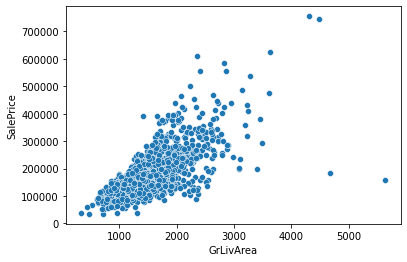

In [5]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)
plt.show()

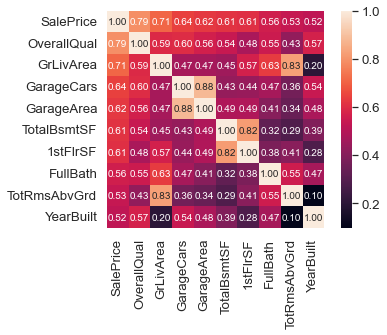

In [6]:
correlation = train.corr()
k = 10 # no of vars in heatmap
cols = correlation.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [7]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
# sns.pairplot(train[cols], size=2.5)

In [8]:
train.isnull().sum().sum()

6965

In [9]:
total = train.isnull().sum().sort_values(ascending=False)
percentage = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])

In [10]:
train = train.drop(missing_data[missing_data['Total'] > 1].index, 1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)

In [11]:
train.isnull().sum().sum()

0

In [12]:
from scipy.stats import norm
from scipy import stats
train['SalePrice'] = np.log1p(train['SalePrice'])

In [13]:
train = pd.get_dummies(train)

In [14]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score

In [17]:
scaler = StandardScaler()
X = train.drop('SalePrice', axis=1)
y = train[['SalePrice']]
X_train, X_test, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(1167, 221)
(292, 221)
(1167, 1)
(292, 1)


In [18]:
# linear regression
l_r = LinearRegression()
l_r.fit(X_train, y_train)
y_train_pred = l_r.predict(X_train)
y_test_pred = l_r.predict(X_test)
scorer = make_scorer(mean_squared_error, greater_is_better=False)
rmse_train = np.sqrt(-cross_val_score(l_r, X_train, y_train, scoring=scorer, cv=10))
rmse_test = np.sqrt(-cross_val_score(l_r, X_test, y_test, scoring=scorer, cv=10))
print('Mean RMSE for train set: ', rmse_train.mean())
print('Mean RMSE for test set: ', rmse_test.mean())

ValueError: Found input variables with inconsistent numbers of samples: [1167, 292]